<a href="https://colab.research.google.com/github/Elmir22/Data-science-ML-models-/blob/main/Emotion_Detection_from_voice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install keras-tuner --upgrade
import keras_tuner as kt
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [71]:
!wget https://raw.githubusercontent.com/Rstam59/TaskDataRepoForStudents/main/helper_functions.py

--2024-06-08 14:45:28--  https://raw.githubusercontent.com/Rstam59/TaskDataRepoForStudents/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-08 14:45:28 (28.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [72]:
from helper_functions import unzip_data

In [73]:
unzip_data("/content/archive (5).zip")

In [74]:
os.walk("/content/files")

<generator object _walk at 0x7ac1102ca650>

In [75]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    stft = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
    features = np.concatenate((np.mean(mfccs, axis=1),
                               np.mean(chroma, axis=1),
                               np.mean(mel, axis=1),
                               np.mean(contrast, axis=1)))
    return features


In [76]:
def load_data(data_dir):
    labels = []
    features = []
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(folder_path, file_name)
                    feature = extract_features(file_path)
                    features.append(feature)
                    labels.append(file_name.split('.')[0])
    return np.array(features), np.array(labels)

In [77]:
data_dir = '/content/files'
X, y = load_data(data_dir)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [78]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]), momentum=0.9)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [79]:
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=5,
                        executions_per_trial=3,
                        directory='tuner_dir',
                        project_name='emotion_recognition')

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.1f}%")

Reloading Tuner from tuner_dir/emotion_recognition/tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                12032     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 160)               10400     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 644       
                                                                 
Total params: 23076 (90.14 KB)
Trainable params: 23076 (90.14 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [80]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense

In [83]:
len('/content/files')

14

In [84]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(512, activation='relu',input_shape=(X_train.shape[1],)),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(len(np.unique(y_encoded)), activation='softmax')

# ])

In [94]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Reshape((187, 1, 1), input_shape=(X_train.shape[1],)),  # Reshape to include channel dimension
#     tf.keras.layers.Conv2D(32, (3, 1), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 1)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(len(np.unique(y_encoded)), activation='softmax')
# ])

In [102]:
len(np.unique(y_encoded))

4

In [104]:
X_train.shape

(54, 187)

In [107]:
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((187, 1), input_shape=(X_train.shape[1],)),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_encoded)), activation='softmax')
])


In [108]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [109]:

history = model.fit(X_train, y_train, epochs = 40, validation_data=(X_test, y_test),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              patience=5,
                                                              verbose=2))

Epoch 1/40
2/2 [==============================] - 3s 762ms/step - loss: 1.5050 - accuracy: 0.2963 - val_loss: 1.4658 - val_accuracy: 0.0714
Epoch 2/40
2/2 [==============================] - 0s 216ms/step - loss: 1.3882 - accuracy: 0.2963 - val_loss: 1.4787 - val_accuracy: 0.0714
Epoch 3/40
2/2 [==============================] - 0s 235ms/step - loss: 1.3814 - accuracy: 0.2778 - val_loss: 1.5528 - val_accuracy: 0.1429
Epoch 4/40
2/2 [==============================] - 0s 243ms/step - loss: 1.3925 - accuracy: 0.2778 - val_loss: 1.5803 - val_accuracy: 0.1429
Epoch 5/40
2/2 [==============================] - 0s 221ms/step - loss: 1.3976 - accuracy: 0.2778 - val_loss: 1.5483 - val_accuracy: 0.1429
Epoch 6/40
2/2 [==============================] - 0s 229ms/step - loss: 1.3882 - accuracy: 0.2778 - val_loss: 1.5374 - val_accuracy: 0.1429
Epoch 6: early stopping


In [110]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 64ms/step - loss: 1.5374 - accuracy: 0.1429


[1.5374109745025635, 0.1428571492433548]

<Axes: >

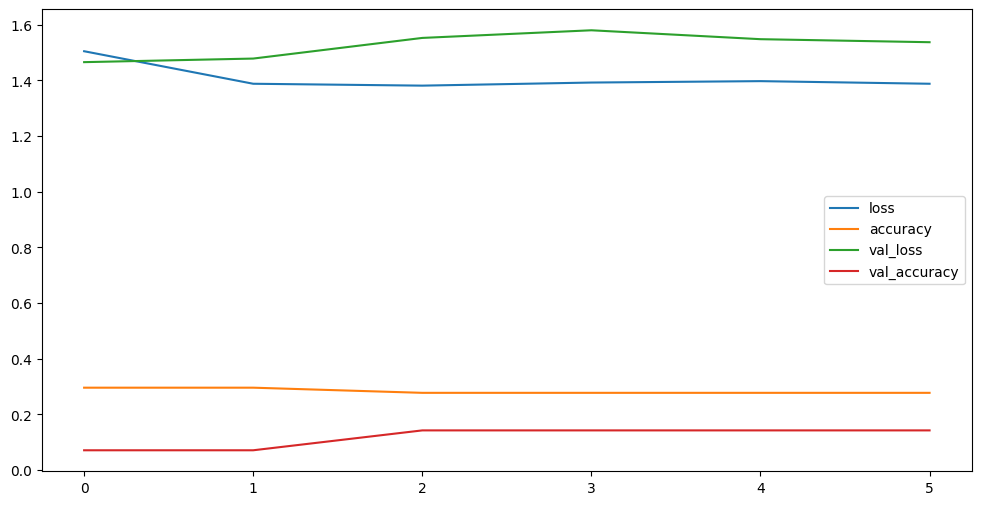

In [111]:

import pandas as pd
pd.DataFrame(history.history).plot(figsize=(12,6))

In [112]:
def predict_emotion(sample_voice):
    feature = extract_features(sample_voice)
    feature = np.expand_dims(feature, axis=0)
    preds = model.predict(feature)
    predict_label= label_encoder.inverse_transform(np.argmax(preds, axis=1))
    return predict_label[0]

In [113]:
sample_voice = '/content/Sad voice .m4a'
predicted_emotion = predict_emotion(sample_voice)
print(f"Predicted Emotion: {predicted_emotion}")

<ipython-input-75-9e94789520a1>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 464ms/step
Predicted Emotion: surprised


#Steps to Build an Emotional Detection Model Using Transfer Learning

In [114]:
pip install tensorflow_hub


In [116]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)


In [129]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the input shape
input_shape=(X_train.shape[1],)

# Create the model
def build_model():
    input_layer = layers.Input(shape=input_shape)
    # Preprocess the input (reshape to 1D)
    x = layers.Reshape((-1,))(input_layer)  # Reshape to (None,)

    # Create a custom layer to encapsulate YAMNet
    class YamnetLayer(layers.Layer):
        def __init__(self, **kwargs):
            super(YamnetLayer, self).__init__(**kwargs)
            self.yamnet_model = yamnet_model  # Use the pre-loaded YAMNet model

        def call(self, inputs):
            # Apply YAMNet to each sample in the batch individually
            embeddings = tf.map_fn(lambda sample: self.yamnet_model(tf.reshape(sample, shape=[-1]))[0], inputs)
            return embeddings

    # Use the custom layer to extract features
    yamnet_features = YamnetLayer()(x)

    # Add custom layers on top of YAMNet
    x = layers.Dense(128, activation='relu')(yamnet_features)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(len(np.unique(y_encoded)), activation='softmax')(x)

    # Define the final model
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

model1 = build_model()

# Compile the model
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 187)]             0         
                                                                 
 reshape_14 (Reshape)        (None, 187)               0         
                                                                 
 yamnet_layer_5 (YamnetLaye  (None, 1, 521)            0         
 r)                                                              
                                                                 
 dense_34 (Dense)            (None, 1, 128)            66816     
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 dense_35 (Dense)            (None, 1, 4)              516       
                                                           

In [131]:
history1 = model1.fit(X_train, y_train, epochs = 40, validation_data=(X_test, y_test),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              patience=5,
                                                              verbose=2))

Epoch 1/40
2/2 [==============================] - 1s 424ms/step - loss: 1.3800 - accuracy: 0.2672 - val_loss: 1.4161 - val_accuracy: 0.1429
Epoch 2/40
2/2 [==============================] - 1s 379ms/step - loss: 1.3782 - accuracy: 0.2891 - val_loss: 1.4195 - val_accuracy: 0.1429
Epoch 3/40
2/2 [==============================] - 1s 320ms/step - loss: 1.3767 - accuracy: 0.2745 - val_loss: 1.4229 - val_accuracy: 0.1429
Epoch 4/40
2/2 [==============================] - 1s 369ms/step - loss: 1.3840 - accuracy: 0.2712 - val_loss: 1.4259 - val_accuracy: 0.1429
Epoch 5/40
2/2 [==============================] - 1s 589ms/step - loss: 1.3833 - accuracy: 0.2818 - val_loss: 1.4286 - val_accuracy: 0.1429
Epoch 6/40
2/2 [==============================] - 1s 713ms/step - loss: 1.3851 - accuracy: 0.2712 - val_loss: 1.4309 - val_accuracy: 0.1429
Epoch 6: early stopping


<Axes: >

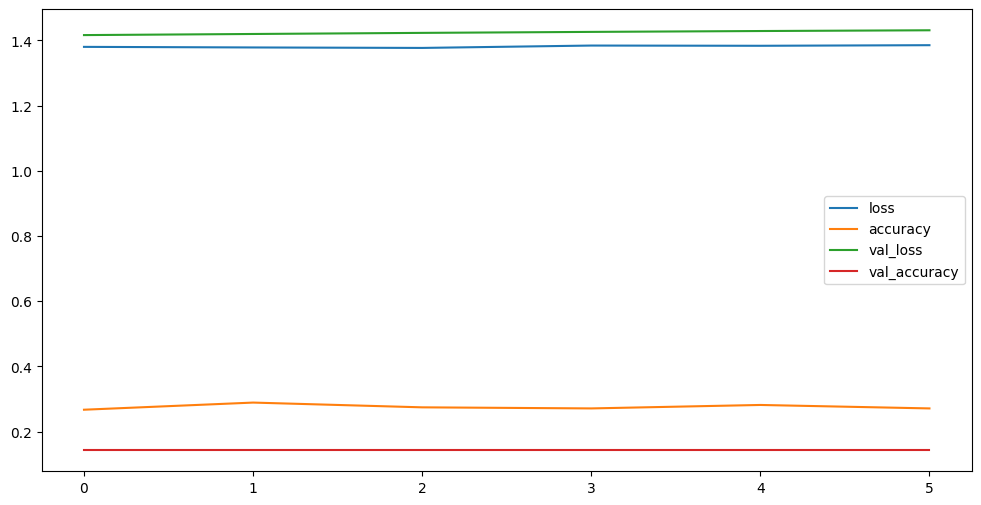

In [133]:
import pandas as pd
pd.DataFrame(history1.history).plot(figsize=(12,6))

In [136]:
def predict_emotion(sample_voice):
    feature = extract_features(sample_voice)
    feature = np.expand_dims(feature, axis=0)
    preds = model1.predict(feature)
    # Get the index of the predicted class for the single sample
    predicted_index = np.argmax(preds[0])
    predict_label = label_encoder.inverse_transform([predicted_index]) # Pass a 1D array
    return predict_label[0]

In [137]:
sample_voice = '/content/Sad voice .m4a'
predicted_emotion = predict_emotion(sample_voice)
print(f"Predicted Emotion: {predicted_emotion}")

<ipython-input-75-9e94789520a1>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 34ms/step
Predicted Emotion: surprised
